<!-- # Simulation Report -->

In [1]:
%load_ext autoreload
%autoreload 2

from ff_energy.simulations import charmm, plots
import matplotlib.pyplot as plt
from IPython.display import display, Markdown, Latex

from ase import Atoms
from ase.geometry import find_mic
import ase.io
from typing import List
import MDAnalysis.analysis.msd as msd
import matplotlib.pyplot as plt
from scipy.stats import linregress
from ase import Atoms
import numpy as np
from ase.io import write
from PIL import Image
from ase.visualize.plot import plot_atoms as ase_plot_atoms
import pandas as pd
from ff_energy.simulations.plots import plot_rdf_exp, plot_rdf_from_file

plt.style.use(['science','ieee',])

def get_atoms(u):
    atoms = u.select_atoms("all")
    ATOMS = []
    for _ in u.trajectory:
        ATOMS.append(get_ase_atoms(u))
    return ATOMS
        
def unwrap(frames: List[Atoms], initial_reference: Atoms=None) -> List[Atoms]:
    """Modifies ``frames`` in-place."""
    if initial_reference is not None:
        ref_frame = initial_reference
    else:
        ref_frame = frames[0]
        frames = frames[1:]

    for frame in frames:
        ref_cart_coords = ref_frame.positions
        cart_coords = frame.positions
        cart_diff, _ = find_mic(cart_coords-ref_cart_coords, cell=frame.cell)
        new_cart_coords = ref_cart_coords + cart_diff
        frame.positions[:] = new_cart_coords
        ref_frame = frame

def get_ase_atoms(u):
    atoms = u.select_atoms("all")
    ase_atoms = Atoms(atoms.masses, atoms.positions, cell = u.dimensions)
    Z = np.tile(np.array([8, 1, 1]), 2000)
    ase_atoms.set_atomic_numbers(Z)
    ase_atoms.set_cell(u.dimensions)
    mid = ase_atoms.get_cell()/2
    ase_atoms.translate(mid.diagonal())
    return ase_atoms


from pint import UnitRegistry
ureg = UnitRegistry()
    
def get_density(volume, nmol=2000):
    ans = nmol*2.988*10**(-23)/volume * ureg("g/angstrom**3")
    return ans.to("kg/m**3")



class DiffusionCoefficient:

    def __init__(self, traj, timestep, atom_indices=None, molecule=False):
        """

        This class calculates the Diffusion Coefficient for the given Trajectory using the Einstein Equation:

        ..math:: \\left \\langle  \\left | r(t) - r(0) \\right | ^{2} \\right \\rangle  = 2nDt

        where r(t) is the position of atom at time t, n is the degrees of freedom and D is the Diffusion Coefficient

        Solved herein by fitting with :math:`y = mx + c`, i.e. :math:`\\frac{1}{2n} \\left \\langle  \\left | r(t) - r(0) \\right | ^{2} \\right \\rangle  = Dt`, with m = D and c = 0

        wiki : https://en.wikibooks.org/wiki/Molecular_Simulation/Diffusion_Coefficients

        Parameters:
            traj (Trajectory):
                Trajectory of atoms objects (images)
            timestep (Float):
                Timestep between *each image in the trajectory*, in ASE timestep units
                (For an MD simulation with timestep of N, and images written every M iterations, our timestep here is N * M)
            atom_indices (List of Int):
                The indices of atoms whose Diffusion Coefficient is to be calculated explicitly
            molecule (Boolean)
                Indicate if we are studying a molecule instead of atoms, therefore use centre of mass in calculations

        """

        self.traj = traj
        self.timestep = timestep

        # Condition used if user wants to calculate diffusion coefficients for
        # specific atoms or all atoms
        self.atom_indices = atom_indices
        if self.atom_indices is None:
            self.atom_indices = [i for i in range(len(traj[0]))]

        # Condition if we are working with the mobility of a molecule, need to
        # manage arrays slightly differently
        self.is_molecule = molecule
        if self.is_molecule:
            self.types_of_atoms = ["molecule"]
            self.no_of_atoms = [1]
        else:
            self.types_of_atoms = sorted(
                set(traj[0].symbols[self.atom_indices]))
            self.no_of_atoms = [traj[0].get_chemical_symbols().count(
                symbol) for symbol in self.types_of_atoms]

        # Dummy initialisation for important results data object
        self._slopes = []

    @property
    def no_of_types_of_atoms(self):
        """

        Dynamically returns the number of different atoms in the system

        """
        return len(self.types_of_atoms)

    @property
    def slopes(self):
        """

        Method to return slopes fitted to datapoints. If undefined, calculate slopes

        """
        if len(self._slopes) == 0:
            self.calculate()
        return self._slopes

    @slopes.setter
    def slopes(self, values):
        """

        Method to set slopes as fitted to datapoints

        """
        self._slopes = values

    def _initialise_arrays(self, ignore_n_images, number_of_segments):
        """

        Private function to initialise data storage objects. This includes objects to store the total timesteps
        sampled, the average diffusivity for species in any given segment, and objects to store gradient and intercept from fitting.

        Parameters:
            ignore_n_images (Int):
                Number of images you want to ignore from the start of the trajectory, e.g. during equilibration
            number_of_segments (Int):
                Divides the given trajectory in to segments to allow statistical analysis

        """

        total_images = len(self.traj) - ignore_n_images
        self.no_of_segments = number_of_segments
        self.len_segments = total_images // self.no_of_segments

        # These are the data objects we need when plotting information. First
        # the x-axis, timesteps
        self.timesteps = np.linspace(
            0, total_images*self.timestep, total_images+1)
        # This holds all the data points for the diffusion coefficients,
        # averaged over atoms
        self.xyz_segment_ensemble_average = np.zeros(
            (self.no_of_segments, self.no_of_types_of_atoms, 3, self.len_segments))
        # This holds all the information on linear fits, from which we get the
        # diffusion coefficients
        self.slopes = np.zeros(
            (self.no_of_types_of_atoms, self.no_of_segments, 3))
        self.intercepts = np.zeros(
            (self.no_of_types_of_atoms, self.no_of_segments, 3))

        self.cont_xyz_segment_ensemble_average = 0

    def calculate(self, ignore_n_images=0, number_of_segments=1):
        """

        Calculate the diffusion coefficients, using the previously supplied data. The user can break the data into segments and
        take the average over these trajectories, therefore allowing statistical analysis and derivation of standard deviations.
        Option is also provided to ignore initial images if data is perhaps unequilibrated initially.

        Parameters:
            ignore_n_images (Int):
                Number of images you want to ignore from the start of the trajectory, e.g. during equilibration
            number_of_segments (Int):
                Divides the given trajectory in to segments to allow statistical analysis

        """

        # Setup all the arrays we need to store information
        self._initialise_arrays(ignore_n_images, number_of_segments)

        for segment_no in range(self.no_of_segments):
            start = segment_no*self.len_segments
            end = start + self.len_segments
            seg = self.traj[ignore_n_images+start:ignore_n_images+end]

            # If we are considering a molecular system, work out the COM for the
            # starting structure
            if self.is_molecule:
                com_orig = np.zeros(3)
                for atom_no in self.atom_indices:
                    com_orig += seg[0].positions[atom_no] / \
                        len(self.atom_indices)

            # For each image, calculate displacement.
            # I spent some time deciding if this should run from 0 or 1, as the displacement will be zero for
            # t = 0, but this is a data point that needs fitting too and so
            # should be included
            for image_no in range(0, len(seg)):
                # This object collects the xyz displacements for all atom
                # species in the image
                xyz_disp = np.zeros((self.no_of_types_of_atoms, 3))

                # Calculating for each atom individually, grouping by species
                # type (e.g. solid state)
                if not self.is_molecule:
                    # For each atom, work out displacement from start coordinate
                    # and collect information with like atoms
                    for atom_no in self.atom_indices:
                        sym_index = self.types_of_atoms.index(
                            seg[image_no].symbols[atom_no])
                        xyz_disp[sym_index] += np.square(
                            seg[image_no].positions[atom_no] - seg[0].positions[atom_no])

                # Calculating for group of atoms (molecule) and work out squared
                # displacement
                else:
                    com_disp = np.zeros(3)
                    for atom_no in self.atom_indices:
                        com_disp += seg[image_no].positions[atom_no] / \
                            len(self.atom_indices)
                    xyz_disp[0] += np.square(com_disp - com_orig)

                # For each atom species or molecule, use xyz_disp to calculate
                # the average data
                for sym_index in range(self.no_of_types_of_atoms):
                    # Normalise by degrees of freedom and average overall atoms
                    # for each axes over entire segment
                    denominator = (2*self.no_of_atoms[sym_index])
                    for xyz in range(3):
                        self.xyz_segment_ensemble_average[segment_no][sym_index][xyz][image_no] = (
                            xyz_disp[sym_index][xyz]/denominator)

            # We've collected all the data for this entire segment, so now to
            # fit the data.
            for sym_index in range(self.no_of_types_of_atoms):
                self.slopes[sym_index][segment_no], self.intercepts[sym_index][segment_no] = self._fit_data(self.timesteps[start:end],
                                                                                                            self.xyz_segment_ensemble_average[segment_no][sym_index])

    def _fit_data(self, x, y):
        """
        Private function that returns slope and intercept for linear fit to mean square diffusion data


        Parameters:
            x (Array of floats):
                Linear list of timesteps in the calculation
            y (Array of floats):
                Mean square displacement as a function of time.

        """
        # Simpler implementation but disabled as fails Conda tests.
        # from scipy.stats import linregress
        # slope, intercept, r_value, p_value, std_err = linregress(x,y)

        # Initialise objects
        slopes = np.zeros(3)
        intercepts = np.zeros(3)

        # Convert into suitable format for lstsq
        x_edited = np.vstack([np.array(x), np.ones(len(x))]).T
        # Calculate slopes for x, y and z-axes
        for xyz in range(3):
            slopes[xyz], intercepts[xyz] = np.linalg.lstsq(
                x_edited, y[xyz], rcond=-1)[0]

        return slopes, intercepts

    def get_diffusion_coefficients(self):
        """

        Returns diffusion coefficients for atoms (in alphabetical order) along with standard deviation.

        All data is currently passed out in units of Å^2/<ASE time units>
        To convert into Å^2/fs => multiply by ase.units.fs
        To convert from Å^2/fs to cm^2/s => multiply by (10^-8)^2 / 10^-15 = 10^-1

        """

        slopes = [np.mean(self.slopes[sym_index])
                  for sym_index in range(self.no_of_types_of_atoms)]
        std = [np.std(self.slopes[sym_index])
               for sym_index in range(self.no_of_types_of_atoms)]

        return slopes, std

    def plot(self, ax=None, show=False, true_D=None):
        """

        Auto-plot of Diffusion Coefficient data. Provides basic framework for visualising analysis.

         Parameters:
            ax (Matplotlib.axes.Axes)
                Axes object on to which plot can be created
            show (Boolean)
                Whether or not to show the created plot. Default: False

        """

        # Necessary if user hasn't supplied an axis.
        import matplotlib.pyplot as plt

        # Convert from ASE time units to fs (aesthetic)
        from ase.units import fs as fs_conversion

        if ax is None:
            ax = plt.gca()

        # Define some aesthetic variables
        color_list = plt.cm.Set3(np.linspace(0, 1, self.no_of_types_of_atoms))
        xyz_labels = ['X', 'Y', 'Z']
        xyz_markers = ['o', 's', '^']

        # Create an x-axis that is in a more intuitive format for the view
        graph_timesteps = self.timesteps / fs_conversion
        # graph_timesteps = graph_timesteps * 1000

        for segment_no in range(self.no_of_segments):
            start = segment_no*self.len_segments
            end = start + self.len_segments
            label = None

            for sym_index in range(self.no_of_types_of_atoms):
                for xyz in range(3):
                    if segment_no == 0:
                        label = 'Species: %s (%s)' % (
                            self.types_of_atoms[sym_index], xyz_labels[xyz])
                    # Add scatter graph  for the mean square displacement data
                    # in this segment
                    ax.scatter(graph_timesteps[start:end]/10000, self.xyz_segment_ensemble_average[segment_no][sym_index][xyz],
                               color="gray", 
                               # marker=xyz_markers[xyz], 
                               label=label, 
                               alpha=0.01,
                               linewidth=0, 
                               edgecolor='grey')

                # Print the line of best fit for segment
                line = np.mean(self.slopes[sym_index][segment_no])*fs_conversion * \
                    graph_timesteps[start:end] + \
                    np.mean(self.intercepts[sym_index][segment_no])
                if segment_no == 0:
                    label = 'Segment Mean : %s' % (
                        self.types_of_atoms[sym_index])
                ax.plot(graph_timesteps[start:end]/10000, line, color='C%d' % (
                    sym_index), label=label, linestyle='--')

            # Plot separator at end of segment
            x_coord = graph_timesteps[end-1]/10000
            print(x_coord)
            ax.plot([x_coord,
                     x_coord],
                    [-0.001,
                     1.05*np.amax(self.xyz_segment_ensemble_average)],
                    color='grey',
                    linestyle=":")
            
        if true_D is not None:
            ax.plot([0,
                     graph_timesteps[end]/10000],
                    [0,
                     true_D/np.mean(self.slopes[sym_index][segment_no]) 
                     * np.amax(self.xyz_segment_ensemble_average) + 
                     np.amax(self.xyz_segment_ensemble_average)],
                    color='k',
                    linestyle="--")
            

        # Plot the overall mean (average of slopes) for each atom species
        # This only makes sense if the data is all plotted on the same x-axis timeframe, which currently we are not - everything is plotted sequentially
        # for sym_index in range(self.no_of_types_of_atoms):
        #    line = np.mean(self.slopes[sym_index])*graph_timesteps+np.mean(self.intercepts[sym_index])
        #    label ='Mean, Total : %s'%(self.types_of_atoms[sym_index])
        #    ax.plot(graph_timesteps, line, color='C%d'%(sym_index), label=label, linestyle="-")

        # Aesthetic parts of the plot
        ax.set_ylim(-0.001, 1.05*np.amax(self.xyz_segment_ensemble_average))
        # ax.legend(loc='best')
        ax.set_xlabel('Time (ps)')
        # ax.set_xticks()
        ax.set_ylabel(r'Mean Square Displacement ($\AA^2$)')
        return ax

    def print_data(self, ax):
        """

        Output of statistical analysis for Diffusion Coefficient data. Provides basic framework for understanding calculation.

        """

        from ase.units import fs as fs_conversion

        # Collect statistical data for diffusion coefficient over all segments
        slopes, std = self.get_diffusion_coefficients()

        # Useful notes for any consideration of conversion.
        # Converting gradient from Å^2/fs to more common units of cm^2/s => multiplying by (10^-8)^2 / 10^-15 = 10^-1
        # Converting intercept from Å^2 to more common units of cm^2 => multiply by (10^-8)^2 = 10^-16
        #
        # Note currently in ASE internal time units
        # Converting into fs => divide by 1/(fs_conversion) => multiply by
        # (fs_conversion)

        # Print data for each atom, in each segment.
        for sym_index in range(self.no_of_types_of_atoms):
            print('---')
            print(r'Species: %4s' % self.types_of_atoms[sym_index])
            print('---')
            for segment_no in range(self.no_of_segments):
                print(r'Segment   %3d:         Diffusion Coefficient = %.10f Å^2/fs; Intercept = %.10f Å^2;' %
                      (segment_no, np.mean(self.slopes[sym_index][segment_no])*fs_conversion, np.mean(self.intercepts[sym_index][segment_no])))

        # Print average overall data.
        print('---')
        for sym_index in range(self.no_of_types_of_atoms):
            print('Mean Diffusion Coefficient (X, Y and Z) : %s = %.10f Å^2/fs; Std. Dev. = %.10f Å^2/fs' %
                  (self.types_of_atoms[sym_index], slopes[sym_index]*fs_conversion, std[sym_index]*fs_conversion))
        print('---')

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

<!-- ## Info (parameters) -->

In [2]:
# Parameters
jobpath = "/home/boittier/pcbach/sims4/optpc/water/k325/dynamics.log"
NSAVC = 1000
dt = 0.0002


In [3]:
# #  example parameters
# jobpath = "/home/boittier/pcbach/sims3/mdcm/water/k350/dynamics.log"
# NSAVC = 1000
# dt = 0.0002

In [4]:
logkey = "_".join(jobpath[jobpath.find("sim"):].split("/")[:-1])

display(Markdown(f'# Simulation Report: {logkey}'))

# Simulation Report: sims4_optpc_water_k325

In [5]:
cl = charmm.read_charmm_log(jobpath)
cl.describe()

water.2000.heat.dcd
water.2000.equi.dcd


,vdw,elec,user,time,temp,tot,energy,volume,pressi,presse
count,22735.000000,22735.000000,22735.0,22735.000000,22735.000000,22735.000000,22735.000000,22735.000000,22735.000000,22735.000000
mean,2585.709281,-15291.122325,0.0,1464.190965,323.779556,-11014.467138,16804.208398,64128.800308,-81.521468,-1405.985300
std,103.625811,353.277789,0.0,882.238749,12.951958,546.401138,329.667314,1548.632270,896.661905,981.030968
min,2312.569680,-21621.307490,0.0,0.000000,56.648850,-21200.093230,16376.818090,61816.000000,-4224.289490,-4995.342970
25%,2533.194960,-15358.531425,0.0,711.200000,322.352190,-11050.559670,16727.855320,63403.000000,-672.221830,-2070.612780
50%,2580.868550,-15271.348420,0.0,1469.000000,324.700820,-10977.733000,16790.119460,63711.000000,-62.443720,-1419.204830
75%,2629.119210,-15179.083375,0.0,2226.800000,327.062845,-10896.743775,16849.307890,64079.000000,525.195650,-762.173250
max,3994.948310,-14761.362970,0.0,2984.600000,339.391460,-10616.815710,23447.971120,68921.000000,3492.589480,2887.039680


In [6]:
cl.to_csv(f"{logkey}_sim.csv", index=False)

In [7]:
# cl.groupby("dyna")

In [8]:
NSIM = len(cl.groupby("dyna"))

## Simulation runs

In [9]:
dyna_groupby = cl.groupby("dyna").describe()
# dyna_groupby["mean"]
dyna_groupby[["vdw", "elec", "volume", "temp"]].T

dyna          0: DYNA STRT VERL  10: DYNA RESTRT CPT  11: DYNA RESTRT CPT  \
vdw    count        2000.000000          1500.000000          1500.000000   
       mean         2568.708373          2592.606841          2584.161377   
       std           276.737773            66.779438            66.086743   
       min          2312.569680          2373.762990          2353.832070   
       25%          2453.932400          2547.492610          2539.702880   
       50%          2499.695040          2591.215070          2584.308080   
       75%          2546.545150          2635.964710          2630.802560   
       max          3994.948310          2788.797050          2836.338360   
elec   count        2000.000000          1500.000000          1500.000000   
       mean       -15383.903934        -15296.778541        -15272.026231   
       std          1121.959713           122.039603           123.133749   
       min        -21621.307490        -15680.667830        -15690.912480   
       25%        -15157.565710        -15374.890472        -15358.756063   
       50%        -15072.106600        -15293.297005        -15271.487420   
       75%        -14995.430155        -15213.937340        -15184.288550   
       max        -14761.362970        -14953.972720        -14820.759770   
volume count        2000.000000          1500.000000          1500.000000   
       mean        68921.000000         63585.668000         63692.802667   
       std             0.000000           454.033237           418.172974   
       min         68921.000000         62285.000000         62237.000000   
       25%         68921.000000         63272.000000         63438.250000   
       50%         68921.000000         63586.500000         63718.000000   
       75%         68921.000000         63908.000000         63986.250000   
       max         68921.000000         64703.000000         64729.000000   
temp   count        2000.000000          1500.000000          1500.000000   
       mean          311.160644           324.989313           324.781215   
       std            40.159972             3.412009             3.332171   
       min            56.648850           312.787990           313.687860   
       25%           319.657548           322.628330           322.537672   
       50%           321.768900           324.883000           324.771405   
       75%           323.688658           327.243547           327.062617   
       max           338.772120           337.739700           334.957070   

dyna          12: DYNA RESTRT CPT  13: DYNA RESTRT CPT  14: DYNA RESTRT CPT  \
vdw    count          1500.000000          1500.000000          1500.000000   
       mean           2581.083666          2587.276410          2587.193187   
       std              64.916234            64.223912            66.397524   
       min            2331.963020          2375.335100          2377.948370   
       25%            2539.289620          2545.633240          2543.548145   
       50%            2581.392170          2588.920150          2587.564260   
       75%            2625.403095          2629.352280          2631.940100   
       max            2793.199250          2762.983940          2788.470680   
elec   count          1500.000000          1500.000000          1500.000000   
       mean         -15266.034252        -15281.367923        -15278.373785   
       std             117.360565           118.361409           123.962094   
       min          -15643.037430        -15652.546640        -15663.056170   
       25%          -15349.777625        -15366.993272        -15361.043150   
       50%          -15266.117790        -15279.920960        -15280.379570   
       75%          -15190.094433        -15201.846735        -15195.249958   
       max          -14765.870120        -14887.634590        -14859.546600   
volume count          1500.000000          1500.000000          1500.000000   
       mean          63773.052000   

## Densities

In [10]:
densities = []
for i, v in enumerate(dyna_groupby.volume["mean"].values):
    d = get_density(v)
    display(Markdown(f'density {i+1}: {d}'))
    densities.append(d)
    
densities = [_.magnitude for _ in densities]

density 1: 867.0796999463153 kilogram / meter ** 3

density 2: 939.8344293559989 kilogram / meter ** 3

density 3: 938.253578080889 kilogram / meter ** 3

density 4: 937.0729191383218 kilogram / meter ** 3

density 5: 937.9487372927904 kilogram / meter ** 3

density 6: 937.7810322299355 kilogram / meter ** 3

density 7: 940.1057533502953 kilogram / meter ** 3

density 8: 936.9606273497019 kilogram / meter ** 3

density 9: 939.6920250589571 kilogram / meter ** 3

density 10: 936.9191387463841 kilogram / meter ** 3

density 11: 938.1451514002382 kilogram / meter ** 3

density 12: 939.2068603424229 kilogram / meter ** 3

density 13: 938.4524876601976 kilogram / meter ** 3

density 14: 939.2468344767419 kilogram / meter ** 3

density 15: 940.4163765895491 kilogram / meter ** 3

density 16: 939.421680108515 kilogram / meter ** 3

In [11]:
temps = []
for i, t in enumerate(dyna_groupby.temp["mean"].values):
    display(Markdown(f'temp. {i+1}: {t}'))
    temps.append(t)
    
simT = np.mean(temps[2:])

temp. 1: 311.160644325

temp. 2: 324.98931264666663

temp. 3: 324.78121496666665

temp. 4: 325.1590516133333

temp. 5: 324.8774633333333

temp. 6: 324.88388018666666

temp. 7: 325.17452620472443

temp. 8: 325.0361745

temp. 9: 325.09952292

temp. 10: 325.13660362

temp. 11: 324.91456264666664

temp. 12: 324.8845590533333

temp. 13: 325.01227486

temp. 14: 324.96186084000004

temp. 15: 325.0713257466666

temp. 16: 325.09462658666666

In [12]:
exp_densities = """°C	.0	.1	.2	.3	.4	.5	.6	.7	.8	.9
0	0.999843	0.999850	0.999856	0.999863	0.999869	0.999875	0.999880	0.999886	0.999892	0.999897
1	0.999902	0.999907	0.999911	0.999916	0.999920	0.999925	0.999929	0.999932	0.999936	0.999940
2	0.999943	0.999946	0.999949	0.999952	0.999955	0.999957	0.999960	0.999962	0.999964	0.999965
3	0.999967	0.999969	0.999970	0.999971	0.999972	0.999973	0.999974	0.999974	0.999975	0.999975
4	0.999975	0.999975	0.999974	0.999974	0.999973	0.999973	0.999972	0.999971	0.999970	0.999968
5	0.999967	0.999965	0.999963	0.999961	0.999959	0.999957	0.999954	0.999952	0.999949	0.999946
6	0.999943	0.999940	0.999936	0.999933	0.999929	0.999925	0.999922	0.999917	0.999913	0.999909
7	0.999904	0.999900	0.999895	0.999890	0.999885	0.999879	0.999874	0.999868	0.999863	0.999857
8	0.999851	0.999845	0.999839	0.999832	0.999826	0.999819	0.999812	0.999805	0.999798	0.999791
9	0.999784	0.999776	0.999768	0.999761	0.999753	0.999745	0.999737	0.999728	0.999720	0.999711
10	0.999702	0.999694	0.999685	0.999675	0.999666	0.999657	0.999647	0.999638	0.999628	0.999618
11	0.999608	0.999598	0.999587	0.999577	0.999566	0.999556	0.999545	0.999534	0.999523	0.999512
12	0.999500	0.999489	0.999477	0.999466	0.999454	0.999442	0.999430	0.999417	0.999405	0.999393
13	0.999380	0.999367	0.999355	0.999342	0.999328	0.999315	0.999302	0.999288	0.999275	0.999261
14	0.999247	0.999233	0.999219	0.999205	0.999191	0.999176	0.999162	0.999147	0.999133	0.999118
15	0.999103	0.999087	0.999072	0.999057	0.999041	0.999026	0.999010	0.998994	0.998978	0.998962
16	0.998946	0.998930	0.998913	0.998897	0.998880	0.998863	0.998847	0.998830	0.998813	0.998795
17	0.998778	0.998761	0.998743	0.998725	0.998708	0.998690	0.998672	0.998654	0.998635	0.998617
18	0.998599	0.998580	0.998561	0.998543	0.998524	0.998505	0.998486	0.998467	0.998447	0.998428
19	0.998408	0.998389	0.998369	0.998349	0.998329	0.998309	0.998289	0.998269	0.998248	0.998228
20	0.998207	0.998186	0.998166	0.998145	0.998124	0.998103	0.998081	0.998060	0.998039	0.998017
21	0.997995	0.997974	0.997952	0.997930	0.997908	0.997886	0.997864	0.997841	0.997819	0.997796
22	0.997773	0.997751	0.997728	0.997705	0.997682	0.997659	0.997635	0.997612	0.997589	0.997565
23	0.997541	0.997518	0.997494	0.997470	0.997446	0.997422	0.997397	0.997373	0.997349	0.997324
24	0.997299	0.997275	0.997250	0.997225	0.997200	0.997175	0.997149	0.997124	0.997099	0.997073
25	0.997048	0.997022	0.996996	0.996970	0.996944	0.996918	0.996892	0.996866	0.996839	0.996813
26	0.996786	0.996760	0.996733	0.996706	0.996679	0.996652	0.996625	0.996598	0.996571	0.996543
27	0.996516	0.996488	0.996461	0.996433	0.996405	0.996377	0.996349	0.996321	0.996293	0.996264
28	0.996236	0.996207	0.996179	0.996150	0.996121	0.996093	0.996064	0.996035	0.996006	0.995976
29	0.995947	0.995918	0.995888	0.995859	0.995829	0.995799	0.995770	0.995740	0.995710	0.995680
30	0.99565	0.99562	0.99559	0.99556	0.99553	0.99550	0.99547	0.99544	0.99541	0.99537
31	0.99534	0.99531	0.99528	0.99525	0.99522	0.99519	0.99516	0.99512	0.99509	0.99506
32	0.99503	0.99500	0.99496	0.99493	0.99490	0.99487	0.99484	0.99480	0.99477	0.99474
33	0.99470	0.99467	0.99464	0.99461	0.99457	0.99454	0.99451	0.99447	0.99444	0.99441
34	0.99437	0.99434	0.99431	0.99427	0.99424	0.99420	0.99417	0.99414	0.99410	0.99407
35	0.99403	0.99400	0.99396	0.99393	0.99390	0.99386	0.99383	0.99379	0.99376	0.99372
36	0.99369	0.99365	0.99361	0.99358	0.99354	0.99351	0.99347	0.99344	0.99340	0.99337
37	0.99333	0.99329	0.99326	0.99322	0.99319	0.99315	0.99311	0.99308	0.99304	0.99300
38	0.99297	0.99293	0.99289	0.99286	0.99282	0.99278	0.99274	0.99271	0.99267	0.99263
39	0.99260	0.99256	0.99252	0.99248	0.99244	0.99241	0.99237	0.99233	0.99229	0.99225
40	0.99222	0.99218	0.99214	0.99210	0.99206	0.99202	0.99199	0.99195	0.99191	0.99187
41	0.99183	0.99179	0.99175	0.99171	0.99167	0.99163	0.99159	0.99156	0.99152	0.99148
42	0.99144	0.99140	0.99136	0.99132	0.99128	0.99124	0.99120	0.99116	0.99112	0.99108
43	0.99104	0.99100	0.99095	0.99091	0.99087	0.99083	0.99079	0.99075	0.99071	0.99067
44	0.99063	0.99059	0.99055	0.99050	0.99046	0.99042	0.99038	0.99034	0.99030	0.99025
45	0.99021	0.99017	0.99013	0.99009	0.99004	0.99000	0.98996	0.98992	0.98988	0.98983
46	0.98979	0.98975	0.98971	0.98966	0.98962	0.98958	0.98953	0.98949	0.98945	0.98941
47	0.98936	0.98932	0.98928	0.98923	0.98919	0.98915	0.98910	0.98906	0.98901	0.98897
48	0.98893	0.98888	0.98884	0.98879	0.98875	0.98871	0.98866	0.98862	0.98857	0.98853
49	0.98848	0.98844	0.98839	0.98835	0.98831	0.98826	0.98822	0.98817	0.98813	0.98808
50	0.98804	0.98799	0.98794	0.98790	0.98785	0.98781	0.98776	0.98772	0.98767	0.98763
51	0.98758	0.98753	0.98749	0.98744	0.98740	0.98735	0.98730	0.98726	0.98721	0.98716
52	0.98712	0.98707	0.98702	0.98698	0.98693	0.98688	0.98684	0.98679	0.98674	0.98670
53	0.98665	0.98660	0.98655	0.98651	0.98646	0.98641	0.98636	0.98632	0.98627	0.98622
54	0.98617	0.98613	0.98608	0.98603	0.98598	0.98593	0.98589	0.98584	0.98579	0.98574
55	0.98569	0.98564	0.98560	0.98555	0.98550	0.98545	0.98540	0.98535	0.98530	0.98525
56	0.98521	0.98516	0.98511	0.98506	0.98501	0.98496	0.98491	0.98486	0.98481	0.98476
57	0.98471	0.98466	0.98461	0.98456	0.98451	0.98446	0.98441	0.98436	0.98431	0.98426
58	0.98421	0.98416	0.98411	0.98406	0.98401	0.98396	0.98391	0.98386	0.98381	0.98376
59	0.98371	0.98366	0.98361	0.98355	0.98350	0.98345	0.98340	0.98335	0.98330	0.98325
60	0.98320	0.98314	0.98309	0.98304	0.98299	0.98294	0.98289	0.98283	0.98278	0.98273
61	0.98268	0.98263	0.98257	0.98252	0.98247	0.98242	0.98237	0.98231	0.98226	0.98221
62	0.98216	0.98210	0.98205	0.98200	0.98194	0.98189	0.98184	0.98179	0.98173	0.98168
63	0.98163	0.98157	0.98152	0.98147	0.98141	0.98136	0.98131	0.98125	0.98120	0.98115
64	0.98109	0.98104	0.98098	0.98093	0.98088	0.98082	0.98077	0.98071	0.98066	0.98061
65	0.98055	0.98050	0.98044	0.98039	0.98033	0.98028	0.98022	0.98017	0.98011	0.98006
66	0.98000	0.97995	0.97989	0.97984	0.97978	0.97973	0.97967	0.97962	0.97956	0.97951
67	0.97945	0.97940	0.97934	0.97929	0.97923	0.97918	0.97912	0.97906	0.97901	0.97895
68	0.97890	0.97884	0.97878	0.97873	0.97867	0.97861	0.97856	0.97850	0.97845	0.97839
69	0.97833	0.97828	0.97822	0.97816	0.97811	0.97805	0.97799	0.97794	0.97788	0.97782
70	0.97776	0.97771	0.97765	0.97759	0.97754	0.97748	0.97742	0.97736	0.97731	0.97725
71	0.97719	0.97713	0.97708	0.97702	0.97696	0.97690	0.97684	0.97679	0.97673	0.97667
72	0.97661	0.97655	0.97650	0.97644	0.97638	0.97632	0.97626	0.97620	0.97614	0.97609
73	0.97603	0.97597	0.97591	0.97585	0.97579	0.97573	0.97567	0.97562	0.97556	0.97550
74	0.97544	0.97538	0.97532	0.97526	0.97520	0.97514	0.97508	0.97502	0.97496	0.97490
75	0.97484	0.97478	0.97472	0.97466	0.97460	0.97454	0.97448	0.97442	0.97436	0.97430
76	0.97424	0.97418	0.97412	0.97406	0.97400	0.97394	0.97388	0.97382	0.97376	0.97370
77	0.97364	0.97358	0.97352	0.97345	0.97339	0.97333	0.97327	0.97321	0.97315	0.97309
78	0.97303	0.97297	0.97290	0.97284	0.97278	0.97272	0.97266	0.97260	0.97253	0.97247
79	0.97241	0.97235	0.97229	0.97223	0.97216	0.97210	0.97204	0.97198	0.97191	0.97185
80	0.97179	0.97173	0.97167	0.97160	0.97154	0.97148	0.97142	0.97135	0.97129	0.97123
81	0.97116	0.97110	0.97104	0.97098	0.97091	0.97085	0.97079	0.97072	0.97066	0.97060
82	0.97053	0.97047	0.97041	0.97034	0.97028	0.97022	0.97015	0.97009	0.97003	0.96996
83	0.96990	0.96983	0.96977	0.96971	0.96964	0.96958	0.96951	0.96945	0.96939	0.96932
84	0.96926	0.96919	0.96913	0.96906	0.96900	0.96893	0.96887	0.96881	0.96874	0.96868
85	0.96861	0.96855	0.96848	0.96842	0.96835	0.96829	0.96822	0.96816	0.96809	0.96803
86	0.96796	0.96790	0.96783	0.96776	0.96770	0.96763	0.96757	0.96750	0.96744	0.96737
87	0.96731	0.96724	0.96717	0.96711	0.96704	0.96698	0.96691	0.96684	0.96678	0.96671
88	0.96664	0.96658	0.96651	0.96645	0.96638	0.96631	0.96625	0.96618	0.96611	0.96605
89	0.96598	0.96591	0.96585	0.96578	0.96571	0.96565	0.96558	0.96551	0.96544	0.96538
90	0.96531	0.96524	0.96518	0.96511	0.96504	0.96497	0.96491	0.96484	0.96477	0.96470
91	0.96463	0.96457	0.96450	0.96443	0.96436	0.96430	0.96423	0.96416	0.96409	0.96402
92	0.96396	0.96389	0.96382	0.96375	0.96368	0.96361	0.96355	0.96348	0.96341	0.96334
93	0.96327	0.96320	0.96313	0.96306	0.96300	0.96293	0.96286	0.96279	0.96272	0.96265
94	0.96258	0.96251	0.96244	0.96237	0.96230	0.96224	0.96217	0.96210	0.96203	0.96196
95	0.96189	0.96182	0.96175	0.96168	0.96161	0.96154	0.96147	0.96140	0.96133	0.96126
96	0.96119	0.96112	0.96105	0.96098	0.96091	0.96084	0.96077	0.96070	0.96063	0.96056
97	0.96049	0.96042	0.96035	0.96027	0.96020	0.96013	0.96006	0.95999	0.95992	0.95985
98	0.95978	0.95971	0.95964	0.95957	0.95949	0.95942	0.95935	0.95928	0.95921	0.95914
99	0.95907	0.95899	0.95892	0.95885	0.95878	0.95871	0.95864	0.95856	0.95849	0.95842"""
exp_densities = [[float(x) for x in _.split("\t")[:2]] for _ in exp_densities.split("\n")[1:]]

In [13]:
# plots.make_plots(cl)

In [14]:
from ase.visualize import view
import MDAnalysis as mda

In [15]:
fn = "water.2000.dyna.dcd"
# fn = "water.2000.dyna.0.dcd"
from pathlib import Path
dcdpaths = []
dcdnames = set(list(cl.groupby("dyna").dcd.max()))
for dcdname in dcdnames:
    dcdpaths.append(Path(jobpath).parents[0] / dcdname)
psfpath = Path(jobpath).parents[0] / "water.2000.psf"

for i in range(NSIM - len(dcdnames)):
    dcdpaths.append(Path(jobpath).parents[0] / 
                    "water.2000.dyna.{0}.dcd".format(i))

##  Trajectory info.

In [16]:
u = mda.Universe(psfpath, dcdpaths[2:4])
print(u)
print(u.trajectory)

/home/boittier/miniconda3/envs/pycharmm/lib/python3.8/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


<Universe with 6000 atoms>
<ChainReader containing water.2000.dyna.0.dcd, water.2000.dyna.1.dcd with 2000 frames of 6000 atoms>


In [17]:
ATOMS = get_atoms(u)
unwrap(ATOMS)

In [18]:
time_ps = len(ATOMS) * NSAVC * dt
display(Markdown(f'sim. time : {time_ps:.0f} (ps)'))

sim. time : 400 (ps)

In [19]:
# ax = plt.gca()
# _ = plots.plot_rdf(ax, u, step=1, title=f"{logkey}_rdf")

##  $MSD$ and $D$

In [20]:
water_D = """0 °C	273.15 K	1.130
10 °C	283.15 K	1.536
20 °C	293.15 K	2.022
25 °C	298.15 K	2.296
30 °C	303.15 K	2.590
40 °C	313.15 K	3.240
50 °C	323.15 K	3.968
60 °C	333.15 K	4.772
70 °C	343.15 K	5.646
80 °C	353.15 K	6.582
90 °C	363.15 K	7.578
100 °C	373.15 K	8.623
0 °C	273.15 K	1.130
10 °C	283.15 K	1.536
20 °C	293.15 K	2.022
25 °C	298.15 K	2.296
30 °C	303.15 K	2.590
40 °C	313.15 K	3.240
50 °C	323.15 K	3.968
60 °C	333.15 K	4.772
70 °C	343.15 K	5.646
80 °C	353.15 K	6.582
90 °C	363.15 K	7.578
100 °C	373.15 K	8.623
4 °C	277.15 K	1.27
10 °C	283.15 K	1.55
25 °C	298.15 K	2.30
45 °C	318.15 K	3.55
60 °C	333.15 K	4.70
15 °C	288.15 K	1.756
20 °C	293.15 K	2.023
25 °C	298.15 K	2.317
30 °C	303.15 K	2.616
15 °C	288.15 K	1.766
20 °C	293.15 K	2.025
25 °C	298.15 K	2.299
30 °C	303.15 K	2.597
35 °C	308.15 K	2.895
40 °C	313.15 K	3.222
45 °C	318.15 K	3.601
50 °C	323.15 K	3.983
56 °C	329.15 K	4.444
–30.65 °C	242.5 K	0.187
–28.75 °C	244.4 K	0.219
–26.85 °C	246.3 K	0.263
–24.95 °C	248.2 K	0.321
–23.15 °C	250.0 K	0.341
–21.35 °C	251.8 K	0.395
–19.15 °C	254.0 K	0.438
–17.35 °C	255.8 K	0.477
–14.45 °C	258.7 K	0.553
–11.65 °C	261.5 K	0.633
–9.45 °C	263.7 K	0.700
0.35 °C	273.5 K	1.05  
12.15 °C	285.3 K	1.58  
25.05 °C	298.2 K	2.23 """
water_D = [_.split("\t")[1:] for _ in water_D.split("\n")]

ks = []
ds = []

for K,D in water_D:
    K = float(K[:6])
    D = float(D)
    ks.append(K)
    ds.append(D)
    
D_exp = pd.DataFrame({"K": ks, "D": ds})
D_exp = D_exp.sort_values("K")

In [21]:
import scipy
from scipy.optimize import curve_fit

D_exp_reg = scipy.stats.linregress(D_exp["K"], y=D_exp["D"])

def x2fit(x, a, b, c):
    return a*x**2 + b*x + c


popt, pcov = curve_fit(x2fit, D_exp["K"], D_exp["D"])

In [22]:
# popt, pcov

In [23]:
# D_exp_reg

In [24]:
exp_densities = np.array(exp_densities)
exp_densities[:,0] = exp_densities[:,0] + 273.15
popt_rho, pcov_rho = curve_fit(x2fit, exp_densities[:,0],  exp_densities[:,1])
# popt_rho

In [25]:
# plt.scatter(exp_densities[:,0], exp_densities[:,1])
# fit_x = np.arange(exp_densities[:,0].min(), exp_densities[:,0].max())
# plt.plot(fit_x, x2fit(fit_x, *popt_rho))

In [26]:
true_density = (x2fit(simT, *popt_rho)) * 1000
display(Markdown(f' true $\\rho$: {true_density:.0f}')) 

 true $\rho$: 987

In [27]:
# plt.scatter(D_exp["K"], D_exp["D"])
# fit_x = np.arange(D_exp["K"].min(), D_exp["K"].max())
# # plt.plot(fit_x, x2fit(fit_x, *popt))

In [28]:
true_D = (x2fit(simT, *popt))  * 10**-5
display(Markdown(f' true $D$: {true_D:.2e}')) 

 true $D$: 4.11e-05

In [29]:
dt

0.0002

In [30]:

dc = DiffusionCoefficient(ATOMS, NSAVC * dt * 1000)
dc.calculate(ignore_n_images=0)


407.0166167328458


<Axes: xlabel='Time (ps)', ylabel='Mean Square Displacement ($\\AA^2$)'>

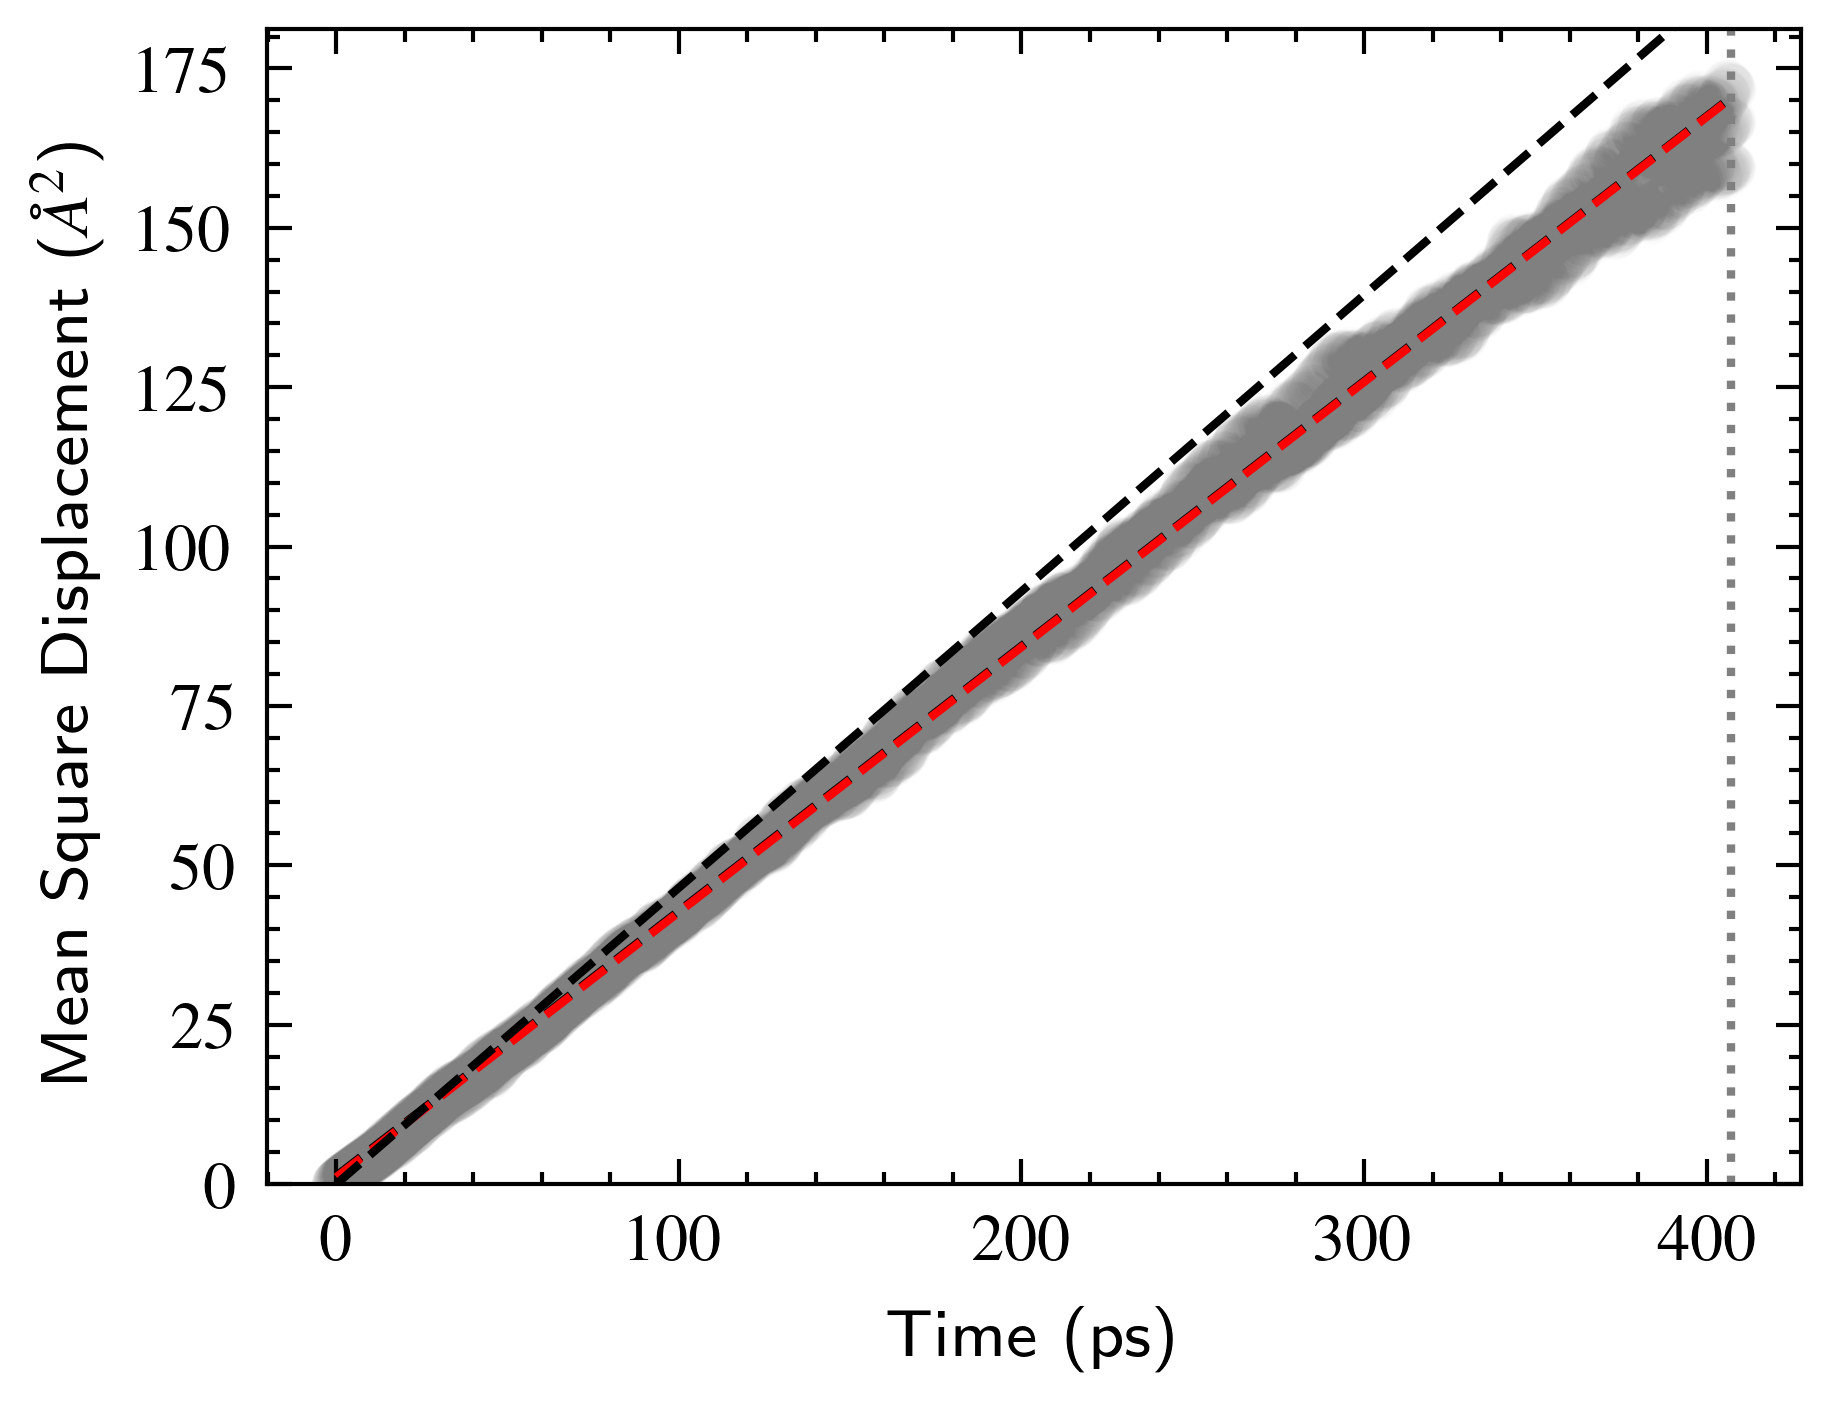

In [31]:


dc.plot(true_D=true_D)
# # dc.print_data(ax=None)
# print([ [__*10**-1 for __ in _] 
#        for _ in dc.get_diffusion_coefficients() ])

#  Structure and Transport

407.0166167328458


D:t,s 4.109212658529831e-05 4.23033157030892
den:t,s 987.2996604993829 938.6305087453959


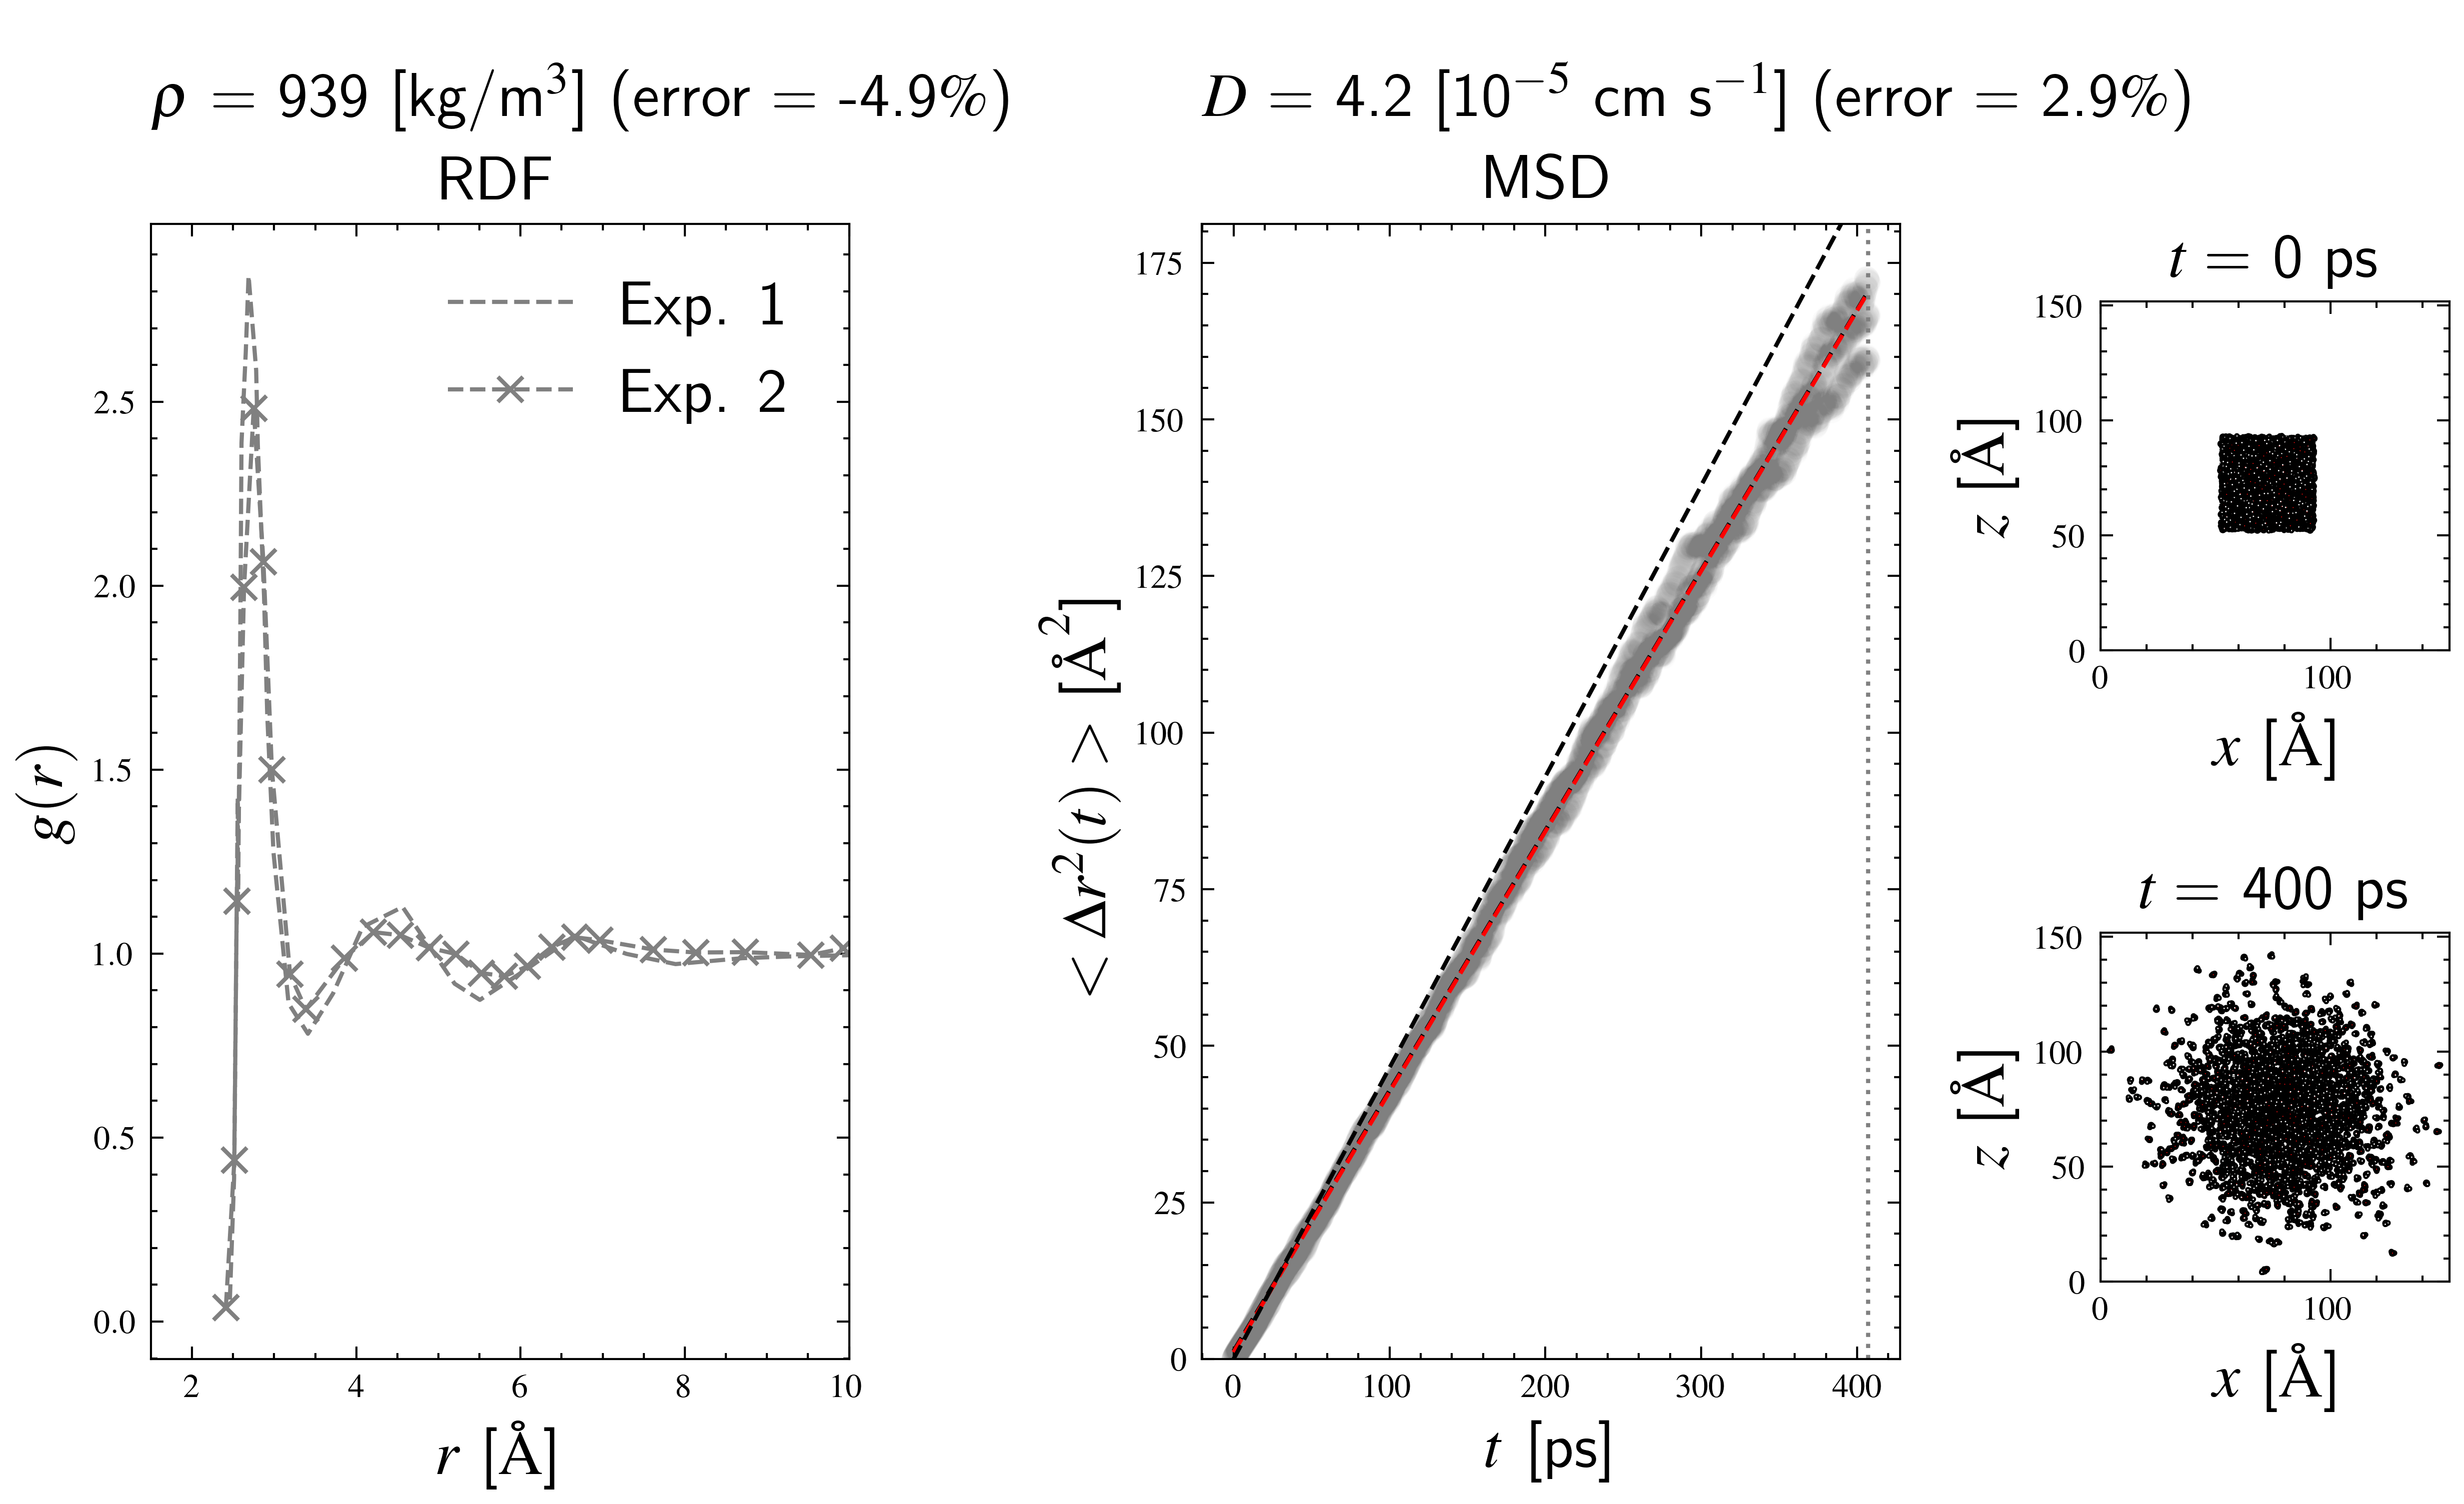

In [32]:
axd = plt.figure(layout="constrained", figsize=(8.2,5)).subplot_mosaic(
    """
    abb
    ABc
    ABd
    """,
    # set the height ratios between the rows
    height_ratios=[0.1, 0.5,0.5],
    # set the width ratios between the columns
    width_ratios=[4, 4, 2],
)

#  RDFs
# plots.plot_rdf_from_file(f"{logkey}_rdf_rdf.csv",
#                          axd["A"])
plot_rdf_exp(axd["A"])
plt.xlim(0,10)
font_size = 15
axd["A"].set_xlabel("$r$ [$\mathrm{\AA}$]", fontsize=font_size)
axd["A"].set_ylabel("$g(r)$", fontsize=font_size)
axd["A"].set_title("RDF", fontsize=font_size, fontweight="bold")
axd["A"].legend(fontsize=font_size)
axd["A"].set_xlim(1.5,10)

# MSDs
ase_plot_atoms(ATOMS[-1], axd["d"])
sqd = axd['d'].get_xlim()[1]
ase_plot_atoms(ATOMS[0], axd["c"], offset=(sqd*1/3,sqd*1/3))
axd["c"].set_xlim(0,sqd)
axd["c"].set_ylim(0,sqd)
axd["c"].set_xlabel("$x$ [$\mathrm{\AA}$]",fontsize=font_size)
axd["c"].set_ylabel("$z$ [$\mathrm{\AA}$]",fontsize=font_size)
axd["d"].set_title(f"$t =$ {time_ps:.0f} ps",fontsize=font_size)
axd["c"].set_title("$t =$ 0 ps",fontsize=font_size)
axd["d"].set_xlim(0,sqd)
axd["d"].set_ylim(0,sqd)
axd["d"].set_xlabel("$x$ [$\mathrm{\AA}$]",fontsize=font_size)
axd["d"].set_ylabel("$z$ [$\mathrm{\AA}$]",fontsize=font_size)
# plot
dc.plot(ax=axd["B"], true_D=true_D)
axd["B"].set_xlabel("$t$ [ps]", fontsize=font_size)
axd["B"].set_ylabel("$<\Delta r^2(t)>$ [$\mathrm{\AA}^{2}$]", fontsize=font_size)
axd["B"].set_title("MSD", fontsize=font_size, fontweight="bold")

#  headers for density and D
axd["b"].axis("off")
D = dc.get_diffusion_coefficients()[0][0] * 0.1



D_pe = (D - true_D)*100/true_D
D = D * 10**5
axd["b"].text(0,0,f"$D$ = {D:.1f} " + "[10$^{-5}$ cm s$^{-1}$]" f" (error = {D_pe:.1f}$\%$)",
              fontsize=font_size/1.)

density = np.mean(densities[1:])
density_pe =  (density - true_density)*100/true_density
axd["a"].text(0,0,f"$\\rho$ = {density:.0f} [kg/m$^{3}$] (error = {density_pe:.1f}$\%$)", 
              fontsize=font_size)
axd["a"].axis("off")

plt.savefig(f"{logkey}_strc_trans.pdf", bbox_inches="tight")

print("D:t,s", true_D, D)
print("den:t,s", true_density, density)

with open(f"{logkey}_prop.csv", "w") as f:
    f.write(f"D,dens\n{D},{density}\n")

